In [55]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import copy
from typing import List, Union, Dict, Any, Callable

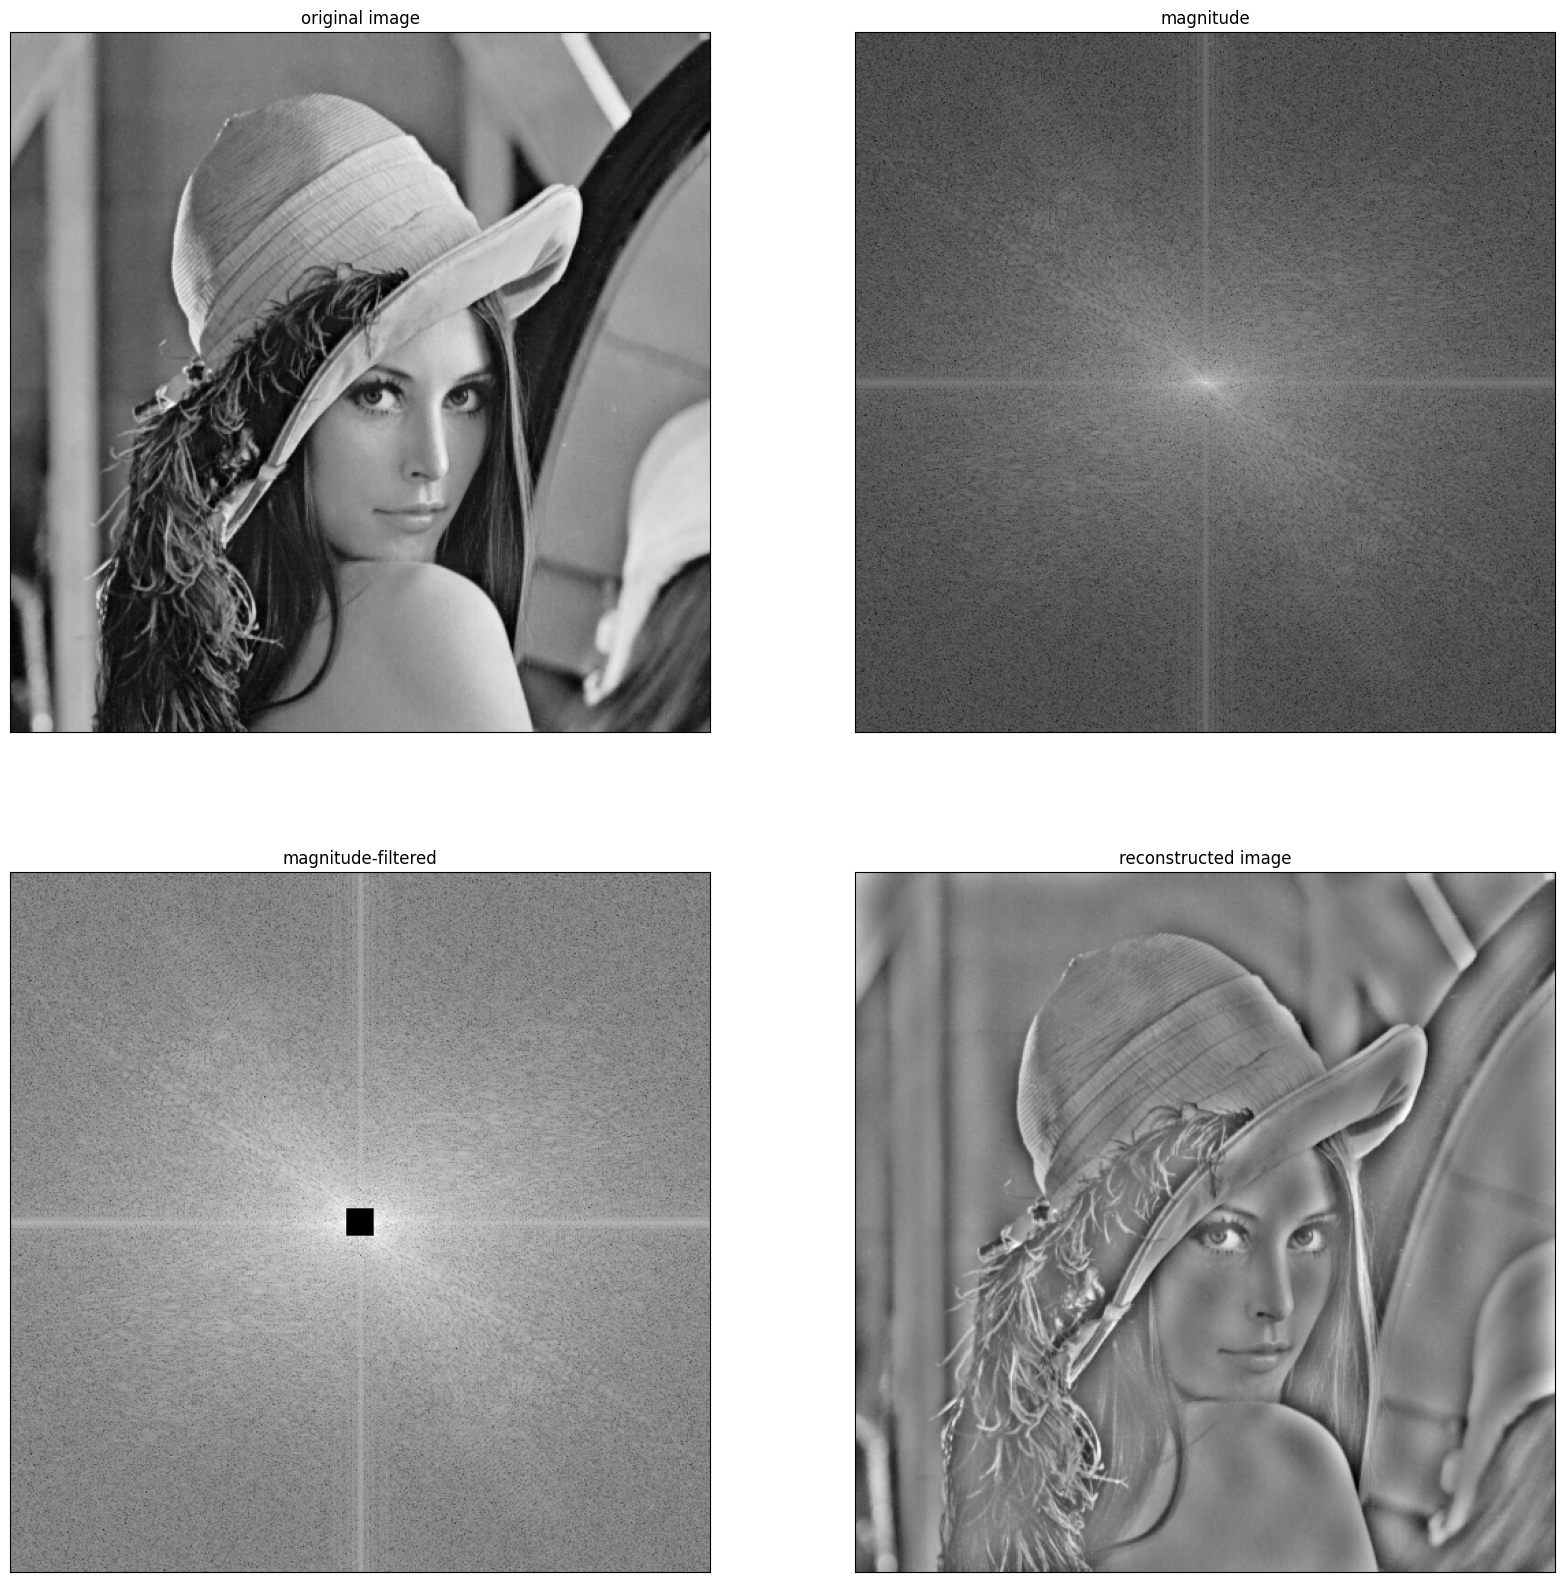

In [56]:
def blur_detector(
    image: List[List], 
    thresh: float, 
    size: int,
    dft: Callable = np.fft.fft2,
    idft: Callable = np.fft.ifft2,
    ret_vis: bool = True) -> Dict[str, Any]:
    '''Computes a mean of any evaluation measure over a set of queries.

    Args:
        image: grayscale image to be evaluated for blur (2d np.array)
        thresh: threshold for which scores you will classsify as blurry or not
        size: half the length (in pixels) of the square used as 
            filter to remove the lower frequencies
        dft: Discrete Fourier Transform function to use
        idft: Inverse Discrete Fourier Transform function to use
        ret_vis: boolean if you want to return the images for each step in the
            process or not

    Returns:
        Dictionary with keys 'is_blurry', 'score' and (optional) 'step_images':
            is_blurry (bool): basically same as score < thresh,
            score (float): a metric of how blurry the image is,
            ret_vis (List[List[List]]): a list of matrices (images) for 
                each step in the process
    '''
    # Make sure image is 2D (Grayscale)
    assert(len(image.shape) == 2)
    h, w = image.shape
    x_center, y_center = int(w / 2.), int(h / 2.)
    # function to calculate the magnitude (0 values are left alone)
    mag = lambda G, scale=20: scale * (np.ma.log(np.abs(G))).filled(0)

    # Take the Discrete Fourier Transform of the image
    G = dft(image)
    # Shift the DC component to the middle
    G_shift = np.fft.fftshift(G)
    # filter out the lower frequencies (set them to 0)
    G_shift_filtered = copy.copy(G_shift)
    G_shift_filtered[(y_center - size) : (y_center + size),
                     (x_center - size) : (x_center + size)] = 0
    # Shift the DC component back to the top left corner
    G_filtered = np.fft.ifftshift(G_shift_filtered)
    recon = idft(G_filtered)
    recon_mag = mag(recon)
    score = np.mean(recon_mag)
    
    # Images that are to be returned for visualization
    step_images = [image, mag(G_shift), mag(G_shift_filtered), np.real(recon)]

    return {
        'is_blurry': score < thresh,
        'score': score,
        'step_images': step_images
    }

lenna = cv2.imread('../data/images/lenna.png', flags=cv2.IMREAD_GRAYSCALE)
r = blur_detector(lenna, 0.5, 10)
plot_images(r['step_images'])